In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [69]:
!git pull https://github.com/rohit-khoiwal-30/msgmt.git

remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 2), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/rohit-khoiwal-30/msgmt
 * branch            HEAD       -> FETCH_HEAD
Updating f426e19..1b35d01
Fast-forward
 bertCONCT.ipynb                          | 681 +------------------------------
 roc/bertCONCT/New Text Document.txt      |   0
 roc/bertEUCL/New Text Document.txt       |   0
 roc/bertTripleLoss/New Text Document.txt |   0
 roc/useCONCT/New Text Document.txt       |   0
 roc/useEUCL/New Text Document.txt        |   0
 roc/useTripleLoss/New Text Document.txt  |   0
 7 files changed, 1 insertion(+), 680 deletions(-)
 create mode 100644 roc/bertCONCT/New Text Document.txt
 create mode 100644 roc/bertEUCL/New Text Document.txt
 create mode 100644 roc/bertTripleLoss/New Text Document.txt
 create mode 100644 roc/useCONCT/New Text Docum

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("augment_train.csv")
df_test = pd.read_csv("evaluation.csv")

In [6]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
from keras.regularizers import l2


try:
    import tensorflow_hub as hub
except ModuleNotFoundError:
    %pip install tensorflow_hub
    import tensorflow_hub as hub
    
try:
    from keras_self_attention import SeqSelfAttention
except ModuleNotFoundError:
    %pip install -q keras-self-attention
    from keras_self_attention import SeqSelfAttention

import numpy as np
import math as m

In [7]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    text_batch, reason_batch, nonreason_batch, y_hat = [], [], [], []
    all_groups = list(range(in_groups[0].shape[0]))

    group_idx = np.random.choice(all_groups, size = batch_halfsize*2)
    text_batch += [in_groups[0][c_idx] for c_idx in group_idx]
    
    b_group_idx = group_idx
    y_hat += [1]*batch_halfsize
    reason_batch += [in_groups[1][c_idx] for c_idx in b_group_idx]
    

    non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
    b_group_idx = non_group_idx
    y_hat += [0]*batch_halfsize
    nonreason_batch += [in_groups[1][c_idx] for c_idx in b_group_idx]
            
    return np.stack(text_batch, 0), np.stack(reason_batch, 0), np.stack(nonreason_batch, 0), np.stack(y_hat, 0)

def siam_gen(in_groups, batch_size = 32):
    while True:
        text_stack, reason_stack, nonreason_stack, y_hatstack = gen_random_batch(in_groups, batch_size//2)
        yield [text_stack, reason_stack, nonreason_stack], y_hatstack


def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [8]:
def accuracy(y_true, y_pred):
    results = (y_pred >= 0.5).astype(int).squeeze()
    return np.mean([y_true == results])

In [9]:
huburl = "https://tfhub.dev/google/universal-sentence-encoder/4" 
fine_tuned_module_object = hub.load(huburl)

In [10]:
def encoder1(name):
    inputs = Input(shape=(), dtype=tf.string)

    shared_embedding_layer = hub.KerasLayer(fine_tuned_module_object, trainable=True, name=name)
    embedding_output= shared_embedding_layer(inputs)
    a = tfl.Dense(128, activation="linear", kernel_regularizer=l2(1e-3))(embedding_output)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(64, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    outputs = tfl.Activation('relu')(a)
    # outputs = tfl.Lambda(lambda x: K.l2_normalize(x,axis=-1))(a)
    
    model = Model(inputs, outputs)
    return model

def encoder2(name):
    inputs = Input(shape=(), dtype=tf.string)

    shared_embedding_layer = hub.KerasLayer(fine_tuned_module_object, trainable=True, name=name)
    embedding_output= shared_embedding_layer(inputs)
    a = tfl.Dense(64, activation="linear", kernel_regularizer=l2(1e-3))(embedding_output)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    outputs = tfl.Activation('relu')(a)
    # outputs = tfl.Lambda(lambda x: K.l2_normalize(x,axis=-1))(a)
    
    model = Model(inputs, outputs)
    return model

In [11]:
def get_model():
    #textEncoder
    inputText = Input(shape=(), dtype=tf.string)
    textModel = encoder1("textBertEncoder")
    text_embedd = textModel(inputText)

    #reasonEncoder
    reasonModel = encoder2("reasonBertEncoder")

    inputReason = Input(shape=(), dtype=tf.string)
    reason_embedd = reasonModel(inputReason)

    #nonReasonEncoder
    inputNotReason = Input(shape=(), dtype=tf.string)
    nonreason_embedd = reasonModel(inputNotReason)

    loss = tfl.Lambda(triplet_loss)([text_embedd, reason_embedd, nonreason_embedd])

    model = Model(inputs = [inputText, inputReason, inputNotReason], outputs = [loss], name="bertModel")
    return model, textModel, reasonModel

In [12]:
model, textModel, reasonModel = get_model()

In [13]:
model.summary()

Model: "bertModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 model (Functional)             (None, 32)           256874720   ['input_1[0][0]']                
                                                                                          

In [14]:
model.compile(optimizer="adam", loss = identity_loss)

In [15]:
eval_df = df_test[df_test['label'] == 1]

In [16]:
loss_history = model.fit(siam_gen([df["texts"], df["reason"]], 128), 
                         validation_data = siam_gen([eval_df["text"].values, eval_df["reason"].values], 128),
                         steps_per_epoch=50, validation_steps=10, epochs = 100, 
                         verbose = True, use_multiprocessing=True)

Epoch 1/100
50/50 [==============================] - 55s 727ms/step - loss: 2.6675 - val_loss: 0.7484
Epoch 2/100
50/50 [==============================] - 30s 606ms/step - loss: 1.5717 - val_loss: 0.9383
Epoch 3/100
50/50 [==============================] - 20s 394ms/step - loss: 1.1925 - val_loss: 1.3418
Epoch 4/100
50/50 [==============================] - 20s 396ms/step - loss: 1.0359 - val_loss: 1.4302
Epoch 5/100
50/50 [==============================] - 22s 452ms/step - loss: 0.9112 - val_loss: 1.4385
Epoch 6/100
50/50 [==============================] - 20s 401ms/step - loss: 0.8254 - val_loss: 1.4047
Epoch 7/100
50/50 [==============================] - 20s 400ms/step - loss: 0.7495 - val_loss: 1.2482
Epoch 8/100
50/50 [==============================] - 22s 448ms/step - loss: 0.7061 - val_loss: 1.2023
Epoch 9/100
50/50 [==============================] - 21s 418ms/step - loss: 0.6644 - val_loss: 1.0277
Epoch 10/100
50/50 [==============================] - 20s 395ms/step - loss: 0.616

In [17]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [56]:
left_input = tf.keras.Input(shape=(), dtype=tf.string)
right_input = tf.keras.Input(shape=(), dtype=tf.string)

textEmbedding = textModel(left_input)
reasonEmbedding = reasonModel(right_input)

# distance = euclidean_distance([textEmbedding, reasonEmbedding])
cosine_similiarity=tf.keras.layers.Dot(axes=-1)([textEmbedding, reasonEmbedding])
output = tfl.Activation('sigmoid')(cosine_similiarity)

classifier_model = Model(inputs = [left_input, right_input], outputs = [output], name="classifier_model")

In [57]:
classifier_model.summary()

Model: "classifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 model (Functional)             (None, 32)           256874720   ['input_16[0][0]']               
                                                                                                  
 model_1 (Functional)           (None, 32)           256833120   ['input_17[0][0]']               
                                                                                   

In [58]:
from sklearn.metrics import brier_score_loss as brier_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [59]:
y_preds = classifier_model.predict([df['texts'], df['reason']])
accuracy(df["label"], y_preds)

1.0

In [60]:
max(y_preds), min(y_preds)

(array([0.99922776], dtype=float32), array([0.5], dtype=float32))

In [61]:
y_hat = (y_preds >= 0.5).astype(int)

In [62]:
print("Brier Loss                       : ", brier_loss(df['label'], y_preds))
print("Precision Score                  : ", precision_score(df['label'], y_hat))
print("Recall Score                     : ", recall_score(df['label'], y_hat))
print("F1 Score                         : ", f1_score(df['label'], y_hat))
# print("Roc AUC Score                    : ", roc_auc_score(df['label'], y_preds))
# print("BCE Loss                         : ", log_loss(df['label'], y_preds))

Brier Loss                       :  0.055018774267168544
Precision Score                  :  1.0
Recall Score                     :  1.0
F1 Score                         :  1.0


In [63]:
y_preds = classifier_model.predict([df_test['text'], df_test['reason']])
accuracy(df_test["label"], y_preds)

0.33344444444444443

In [64]:
max(y_preds), min(y_preds)

(array([0.9971597], dtype=float32), array([0.5], dtype=float32))

In [65]:
y_hat = (y_preds >= 0.5).astype(int)

In [66]:
print("Brier Loss                       : ", brier_loss(df_test['label'], y_preds))
print("Precision Score                  : ", precision_score(df_test['label'], y_hat))
print("Recall Score                     : ", recall_score(df_test['label'], y_hat))
print("F1 Score                         : ", f1_score(df_test['label'], y_hat))
print("Roc AUC Score                    : ", roc_auc_score(df_test['label'], y_preds))
print("BCE Loss                         : ", log_loss(df_test['label'], y_preds))

Brier Loss                       :  0.40560934003640103
Precision Score                  :  0.33344444444444443
Recall Score                     :  1.0
F1 Score                         :  0.5001249895842013
Roc AUC Score                    :  0.6322971800420587
BCE Loss                         :  1.11353713406149


In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(df_test['label'], y_preds)
roc_auc = auc(fpr, tpr)

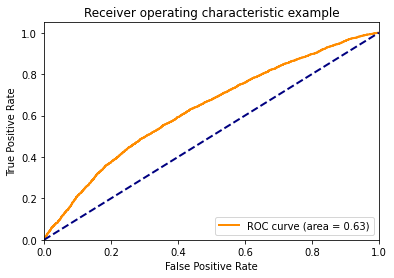

In [68]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [72]:
from numpy import asarray
from numpy import savetxt
# define data
data1 = asarray([fpr])
data2 = asarray([tpr])

# save to csv file
savetxt('roc/useTripleLoss/fprdata.csv', data1, delimiter=',')
savetxt('roc/useTripleLoss/tprdata.csv', data2, delimiter=',')

In [70]:
classifier_model.save("augment_models/useTripletLoss/")